# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import xception
from keras.applications.xception import Xception


import pydot
import cv2
import h5py

Using TensorFlow backend.


In [2]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

xception_train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=xception.preprocess_input)

xception_valid_datagen = ImageDataGenerator(
    preprocessing_function=xception.preprocess_input)


xception_train_generator = xception_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical')

xception_valid_generator = xception_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建模型

In [3]:
model_xception = Xception(include_top=False, weights='imagenet')

for i, layer in enumerate(model_xception.layers):
    print (i, layer.name)
        
input = Input(shape=(299, 299, 3),name = 'image_input')
 
output_xception_conv = model_xception(input)
   
x = GlobalAveragePooling2D()(output_xception_conv)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

##### 三、模型创建
#### 1.锁定Xception模型前35层

In [4]:
model_35 = Model(inputs=input, outputs=x)

for i in range(35):
    model_xception.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_35.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [5]:
history_35 = model_35.fit_generator(
    xception_train_generator,
    epochs=1,
    validation_data=xception_valid_generator)

Epoch 1/1
315/315 [==============================] - 829s 3s/step - loss: 0.3661 - categorical_accuracy: 0.8969 - val_loss: 0.3499 - val_categorical_accuracy: 0.8986


In [6]:
model_35.save(join(pardir, 'model', 'xception_finetune_35.h5'))
print("xception model saved.")

xception model saved.


{'val_loss': [0.34993658952821616], 'val_categorical_accuracy': [0.8985818651903839], 'categorical_accuracy': [0.8996865203761756], 'loss': [0.36040896057471616]}


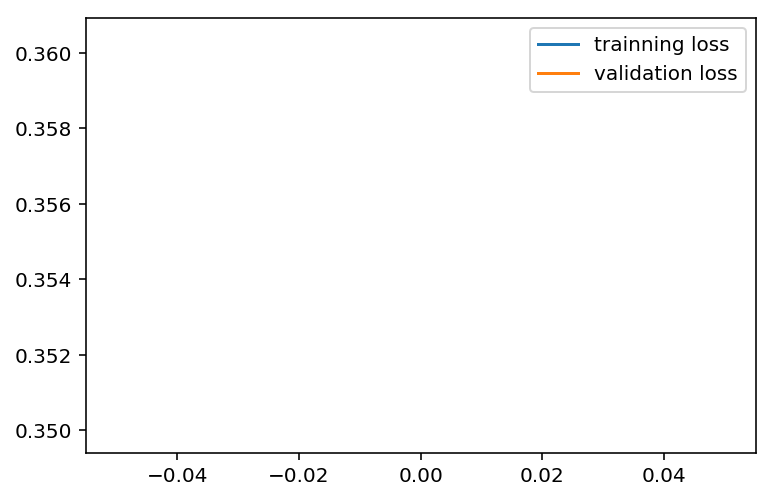

In [7]:
print (history_35.history)
plt.plot (history_35.history['loss'], label="trainning loss")
plt.plot (history_35.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 2.锁定InceptionV3模型前75层

In [4]:
model_75 = Model(inputs=input, outputs=x)

for i in range(75):
    model_xception.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_75.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [5]:
history_75 = model_75.fit_generator(
    xception_train_generator,
    epochs=1,
    validation_data=xception_valid_generator)

Epoch 1/1
315/315 [==============================] - 652s 2s/step - loss: 0.4303 - categorical_accuracy: 0.8781 - val_loss: 0.3238 - val_categorical_accuracy: 0.8934


In [6]:
model_75.save(join(pardir, 'model', 'xception_finetune_75.h5'))
print("Xception model saved.")

Xception model saved.


{'categorical_accuracy': [0.8808777429467085], 'val_loss': [0.3238007144119589], 'loss': [0.42382314521981546], 'val_categorical_accuracy': [0.8934250107946753]}


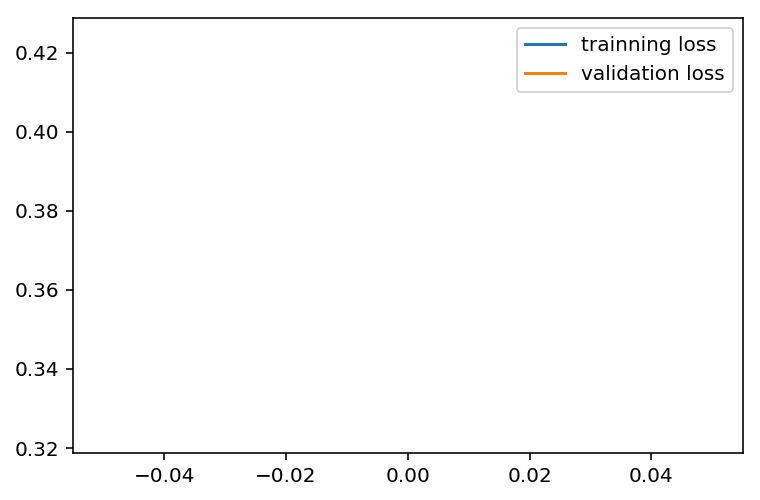

In [7]:
print (history_75.history)
plt.plot (history_75.history['loss'], label="trainning loss")
plt.plot (history_75.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 四、模型预测
准备测试集数据

In [8]:
test_image_path = join(driver_dataset_folder_path, 'test')
xception_test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
xception_test_generator = xception_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    class_mode='categorical')

Found 79726 images belonging to 1 classes.


#### 1.model_XceptionV3_finetune_35
模型加载

In [9]:
model_xception_finetune_35 = load_model(join(pardir, 'model', 'xception_finetune_35.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [10]:
pred_xception_finetune_35 = model_xception_finetune_35.predict_generator(xception_test_generator, verbose=1)
print(pred_xception_finetune_35.shape)

2492/2492 [==============================] - 1614s 648ms/step
(79726, 10)


生成kaggle提交文件

In [11]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [12]:
result_xception_finetune_35 = np.append(image_names, pred_xception_finetune_35, axis = 1)
predict_result_xception_finetune_35 = pd.DataFrame(result_xception_finetune_35, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_xception_finetune_35.to_csv('result_xception_finetune_35.csv', index=False)

#### 2.model_Xception_finetune_75
模型加载

In [13]:
model_xception_finetune_75 = load_model(join(pardir, 'model', 'xception_finetune_75.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [14]:
pred_xception_finetune_75 = model_xception_finetune_75.predict_generator(xception_test_generator, verbose=1)
print(pred_xception_finetune_75.shape)

2492/2492 [==============================] - 1617s 649ms/step
(79726, 10)


生成kaggle提交文件

In [15]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [16]:
result_xception_finetune_75 = np.append(image_names, pred_xception_finetune_75, axis = 1)
predict_result_xception_finetune_75 = pd.DataFrame(result_xception_finetune_75, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_xception_finetune_75.to_csv('result_xception_finetune_75.csv', index=False)